In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Trực quan hóa theo ngành

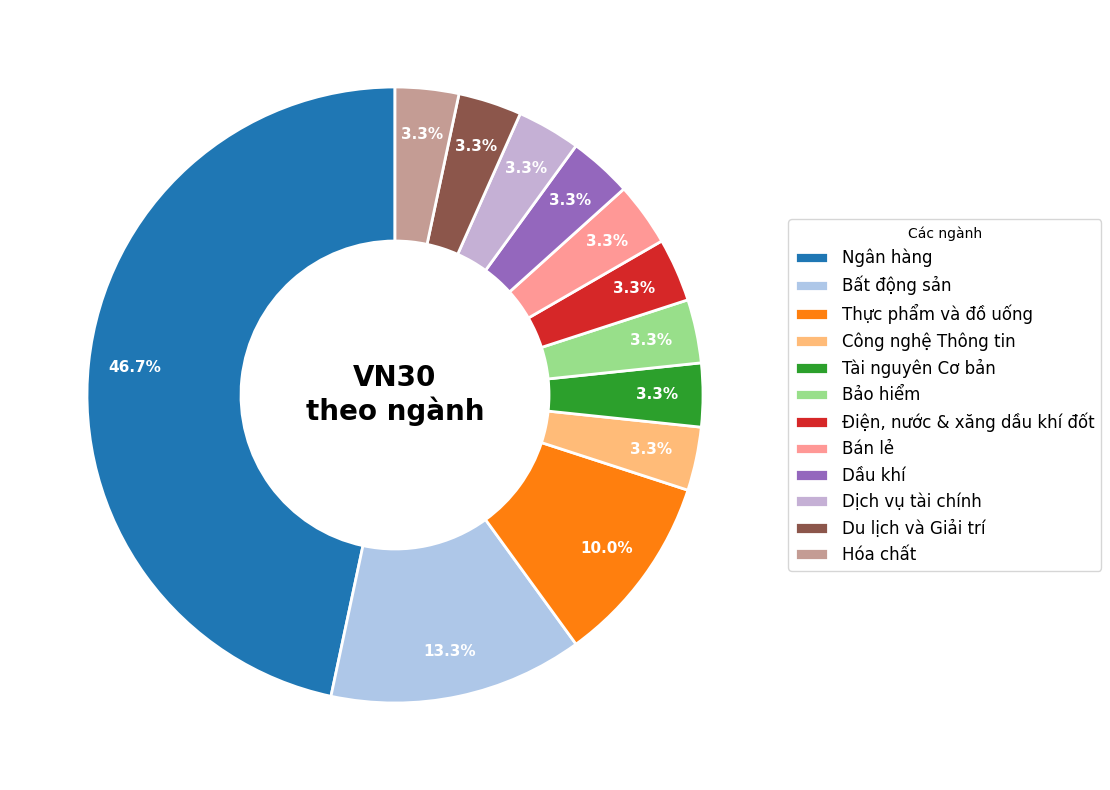

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

df = pd.read_csv('../data/vn30_info.csv')

# Đếm số lượng công ty theo ngành icb_name2
industry_counts = df["icb_name2"].value_counts()

# Tạo bảng màu đẹp hơn
colors = [
    '#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f', 
    '#1abc9c', '#e67e22', '#34495e', '#7f8c8d', '#d35400'
]

# Mở rộng bảng màu nếu có nhiều hơn 10 ngành
if len(industry_counts) > 10:
    colors = plt.cm.tab20(np.arange(len(industry_counts)))

# Tạo figure với kích thước tùy chỉnh
plt.figure(figsize=(12, 8))

# Vẽ biểu đồ tròn với các cải tiến
wedges, texts, autotexts = plt.pie(
    industry_counts, 
    labels=None,  # Không hiển thị nhãn trực tiếp trên biểu đồ
    autopct='%1.1f%%', 
    startangle=90, 
    pctdistance=0.85,
    wedgeprops={
        'edgecolor': 'white',
        'linewidth': 2,
        'antialiased': True,
        'width': 0.5  # Tạo donut chart thay vì pie chart
    },
    colors=colors[:len(industry_counts)],
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'white'},
    shadow=False
)

# Tùy chỉnh văn bản phần trăm
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

# Thêm hình tròn trắng ở giữa để tạo donut chart
circle = plt.Circle((0, 0), 0.3, fc='white')
plt.gca().add_artist(circle)

# Thêm tiêu đề vào giữa biểu đồ
plt.text(0, 0, 'VN30\ntheo ngành', 
         horizontalalignment='center',
         verticalalignment='center', 
         fontsize=20, 
         fontweight='bold')

# Tạo legend riêng với các nhãn và màu tương ứng
plt.legend(
    wedges, 
    industry_counts.index,
    title="Các ngành",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

# Cân bằng không gian cho legend
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

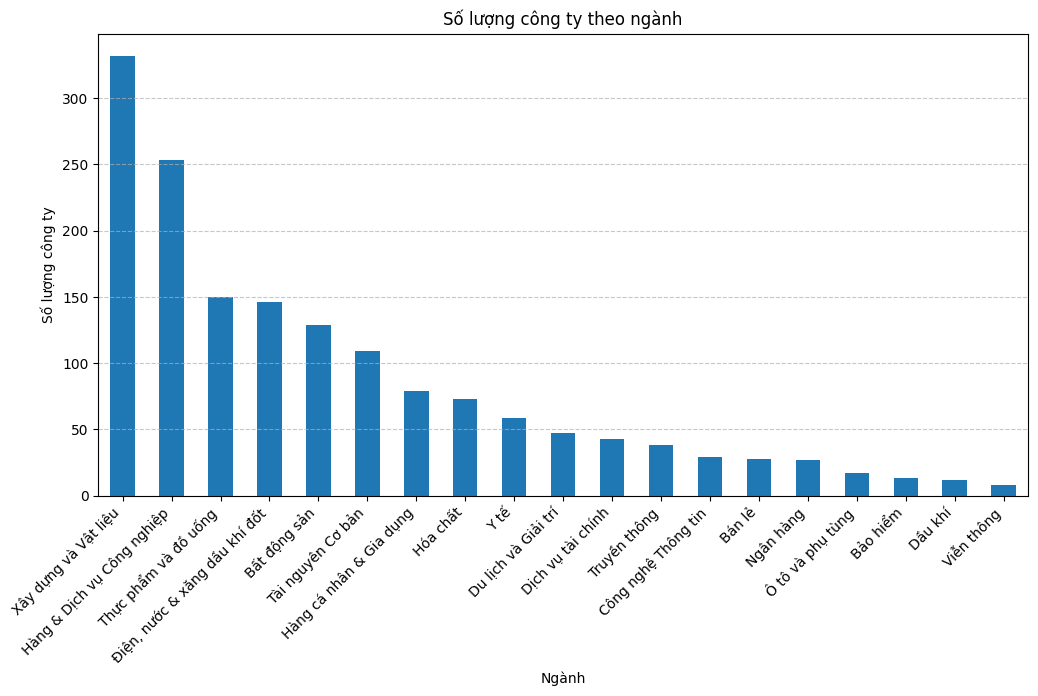

In [9]:
df = pd.read_csv('../data/all_info.csv')

# Đếm số lượng công ty theo ngành icb_name2
industry_counts = df["icb_name2"].value_counts()

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 6))
industry_counts.plot(kind="bar")
plt.xlabel("Ngành")
plt.ylabel("Số lượng công ty")
plt.title("Số lượng công ty theo ngành")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

# 2. Trực quan hóa theo thanh khoản

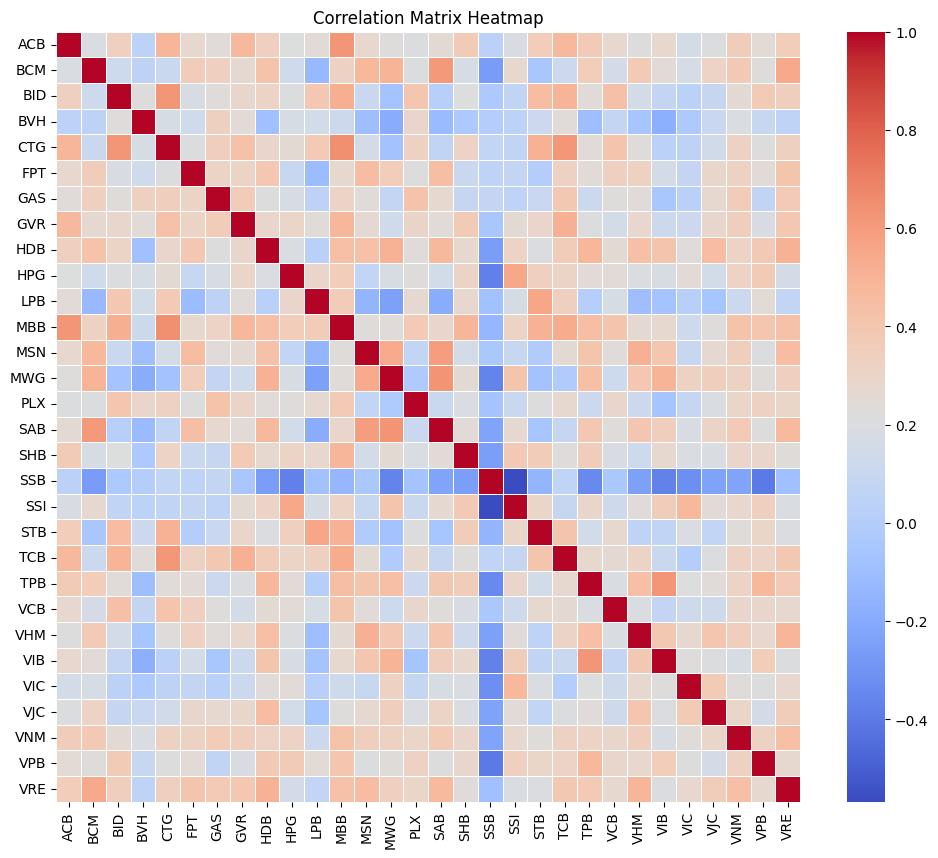

In [11]:
df = pd.read_csv('../data/vn30/volume.csv')

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Drop the 'time' column to compute correlations
df_numeric = df.drop(columns=['time'])

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 10))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

# Title for the heatmap
plt.title("Correlation Matrix Heatmap")

# Display the plot
plt.show()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from datetime import datetime
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# List of VN30 companies
vn30 = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 
        'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 
        'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

# Function to load and preprocess data
def load_data(ticker):
    file_path = f'../data/vn30/metric/{ticker}.csv'
    try:
        df = pd.read_csv(file_path)
        # Convert period to datetime for proper sorting
        df['period'] = pd.to_datetime(df['period'])
        # Filter data from Q1-2020 to Q4-2024
        mask = (df['period'] >= '2020-01-01') & (df['period'] <= '2024-12-31')
        return df[mask].sort_values('period')
    except Exception as e:
        print(f"Error loading {ticker}: {e}")
        return None

# Load all company data
company_data = {}
for company in vn30:
    data = load_data(company)
    if data is not None and not data.empty:
        company_data[company] = data

# Check which companies have complete data
print(f"Successfully loaded data for {len(company_data)} out of {len(vn30)} companies")

# Function to test distribution similarity using Kolmogorov-Smirnov test
def test_distribution_similarity(data1, data2, column):
    """
    Test if two distributions are similar using Kolmogorov-Smirnov test
    Returns p-value which if > 0.05 suggests distributions are similar
    """
    # Clean data by removing NaN values
    clean_data1 = data1[column].dropna()
    clean_data2 = data2[column].dropna()
    
    # Ensure we have enough data points
    if len(clean_data1) < 4 or len(clean_data2) < 4:
        return np.nan
    
    # Perform KS test
    statistic, p_value = stats.ks_2samp(clean_data1, clean_data2)
    return p_value

# Get list of numerical columns to analyze (exclude non-numeric and time-related columns)
def get_numeric_columns(df):
    exclude_cols = ['period', 'quarter', 'year']
    return [col for col in df.columns if col not in exclude_cols]

# Sample company to get columns
sample_company = next(iter(company_data.values()))
numeric_columns = get_numeric_columns(sample_company)
print(f"Analyzing {len(numeric_columns)} financial metrics")

# Create a function to calculate similarity matrix for a specific metric
def calculate_similarity_matrix(metric):
    num_companies = len(company_data)
    similarity_matrix = np.zeros((num_companies, num_companies))
    company_list = list(company_data.keys())
    
    for i, company1 in enumerate(company_list):
        for j, company2 in enumerate(company_list):
            if i == j:
                similarity_matrix[i, j] = 1.0  # Same company, perfect similarity
            elif i < j:  # Calculate only for upper triangle
                p_value = test_distribution_similarity(
                    company_data[company1], 
                    company_data[company2], 
                    metric
                )
                similarity_matrix[i, j] = similarity_matrix[j, i] = p_value
    
    return similarity_matrix, company_list

# Function to visualize similarity matrix
def plot_similarity_matrix(matrix, companies, metric, threshold=0.05):
    """
    Plot similarity matrix as a heatmap
    Highlight cells where p-value > threshold (similar distributions)
    """
    plt.figure(figsize=(14, 12))
    mask = np.isnan(matrix)
    
    # Color similar distributions (p > threshold) differently
    similar_mask = (matrix > threshold) & ~mask
    not_similar_mask = (matrix <= threshold) & ~mask
    
    # Count similar pairs
    total_pairs = np.sum(~mask & ~np.eye(matrix.shape[0], dtype=bool)) / 2  # exclude diagonal and count each pair once
    similar_pairs = np.sum(similar_mask & ~np.eye(matrix.shape[0], dtype=bool)) / 2
    similar_percentage = (similar_pairs / total_pairs) * 100 if total_pairs > 0 else 0
    
    # Custom colormap
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    
    # Plot heatmap
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, linewidths=.5, 
                xticklabels=companies, yticklabels=companies, 
                vmin=0, vmax=1, annot=True, fmt=".2f", annot_kws={"size": 7})
    
    plt.title(f'Distribution Similarity Matrix for {metric}\n'
              f'{similar_percentage:.1f}% of company pairs have similar distributions (p > {threshold})',
              fontsize=14)
    plt.tight_layout()
    return plt.gcf(), similar_percentage

# Analyze all metrics or select a few important ones
key_metrics = [
    'price_to_earning', 'price_to_book', 'roe', 'roa', 
    'earning_per_share', 'book_value_per_share'
]

# Calculate average similarity across all metrics
overall_similar_percentage = 0
overall_similarity_matrix = np.zeros((len(company_data), len(company_data)))
valid_metrics = []

for metric in key_metrics:
    try:
        similarity_matrix, companies = calculate_similarity_matrix(metric)
        
        # Create visualization
        _, similar_pct = plot_similarity_matrix(similarity_matrix, companies, metric)
        plt.savefig(f'similarity_matrix_{metric}.png')
        plt.close()
        
        print(f"Metric: {metric}, Similar distributions: {similar_pct:.1f}%")
        
        # Add to overall similarity (if not nan)
        if not np.isnan(similarity_matrix).all():
            overall_similarity_matrix += np.nan_to_num(similarity_matrix)
            valid_metrics.append(metric)
            overall_similar_percentage += similar_pct
    except Exception as e:
        print(f"Error processing {metric}: {e}")

# Calculate average similarity percentage
if valid_metrics:
    overall_similar_percentage /= len(valid_metrics)
    overall_similarity_matrix /= len(valid_metrics)
    
    # Plot overall similarity
    plt.figure(figsize=(14, 12))
    sns.heatmap(overall_similarity_matrix, cmap="YlGnBu", square=True, linewidths=.5,
                xticklabels=companies, yticklabels=companies, 
                vmin=0, vmax=1, annot=True, fmt=".2f", annot_kws={"size": 7})
    
    plt.title(f'Overall Distribution Similarity (Average across {len(valid_metrics)} metrics)\n'
              f'Average: {overall_similar_percentage:.1f}% of company pairs have similar distributions',
              fontsize=14)
    plt.tight_layout()
    plt.savefig('overall_similarity_matrix.png')
    plt.close()

print(f"\nOverall, {overall_similar_percentage:.1f}% of company pairs have similar distributions across key metrics")

# Enhanced analysis: Cluster companies by similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

# Function to create combined feature matrix for clustering
def create_feature_matrix():
    # Get periods that are common across all companies
    all_periods = set()
    for company, data in company_data.items():
        all_periods.update(data['period'].dt.strftime('%Y-%m').unique())
    all_periods = sorted(all_periods)
    
    feature_data = {}
    
    # For each company, create a feature vector of key metrics across time
    for company, data in company_data.items():
        company_features = []
        for metric in key_metrics:
            if metric in data.columns:
                # Use the metric values as features
                values = data[metric].values
                if len(values) > 0:
                    company_features.extend(values)
        
        if company_features:
            feature_data[company] = company_features
    
    # Create DataFrame with consistent length vectors
    # Pad or truncate as needed
    max_len = max(len(features) for features in feature_data.values())
    for company in feature_data:
        if len(feature_data[company]) < max_len:
            # Pad with NaN
            feature_data[company] = feature_data[company] + [np.nan] * (max_len - len(feature_data[company]))
        elif len(feature_data[company]) > max_len:
            # Truncate
            feature_data[company] = feature_data[company][:max_len]
    
    feature_df = pd.DataFrame(feature_data).T
    return feature_df.fillna(feature_df.mean())

# Create feature matrix and cluster companies
try:
    feature_matrix = create_feature_matrix()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    
    # Calculate linkage
    Z = linkage(scaled_features, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(16, 10))
    dendrogram(Z, labels=feature_matrix.index, leaf_rotation=90)
    plt.title('Hierarchical Clustering of VN30 Companies based on Financial Metrics', fontsize=16)
    plt.xlabel('Companies')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.savefig('company_clustering.png')
    plt.close()
    
    print("Completed hierarchical clustering of companies based on financial similarity")
except Exception as e:
    print(f"Error in clustering analysis: {e}")

print("\nAnalysis complete. Visualizations saved as PNG files.")

Successfully loaded data for 30 out of 30 companies
Analyzing 29 financial metrics
Metric: price_to_earning, Similar distributions: 24.1%
Metric: price_to_book, Similar distributions: 28.3%
Metric: roe, Similar distributions: 14.3%
Metric: roa, Similar distributions: 7.4%
Metric: earning_per_share, Similar distributions: 21.8%
Metric: book_value_per_share, Similar distributions: 17.2%

Overall, 18.9% of company pairs have similar distributions across key metrics
Completed hierarchical clustering of companies based on financial similarity

Analysis complete. Visualizations saved as PNG files.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Danh sách các công ty ngân hàng trong VN30
banks = ['ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB', 'SSB', 'STB', 'TCB', 'TPB', 'VCB', 'VIB', 'VPB']

# Function để đọc và xử lý dữ liệu
def load_data(ticker):
    file_path = f'../data/vn30/metric/{ticker}.csv'
    try:
        df = pd.read_csv(file_path)
        # Chuyển period thành datetime để sắp xếp chính xác
        df['period'] = pd.to_datetime(df['period'])
        # Lọc dữ liệu từ Q1-2020 đến Q4-2024
        mask = (df['period'] >= '2020-01-01') & (df['period'] <= '2024-12-31')
        return df[mask].sort_values('period')
    except Exception as e:
        print(f"Lỗi khi đọc dữ liệu {ticker}: {e}")
        return None

# Đọc dữ liệu cho tất cả ngân hàng
bank_data = {}
for bank in banks:
    data = load_data(bank)
    if data is not None and not data.empty:
        bank_data[bank] = data

print(f"Đã đọc dữ liệu thành công cho {len(bank_data)} trong số {len(banks)} ngân hàng")

# Function kiểm tra sự đồng dạng của phân phối sử dụng Kolmogorov-Smirnov test
def test_distribution_similarity(data1, data2, column):
    """
    Kiểm tra xem hai phân phối có tương tự nhau không sử dụng Kolmogorov-Smirnov test
    Trả về p-value, nếu > 0.05 gợi ý rằng các phân phối tương tự nhau
    """
    # Làm sạch dữ liệu bằng cách loại bỏ các giá trị NaN
    clean_data1 = data1[column].dropna()
    clean_data2 = data2[column].dropna()
    
    # Đảm bảo có đủ điểm dữ liệu
    if len(clean_data1) < 4 or len(clean_data2) < 4:
        return np.nan
    
    # Thực hiện kiểm định KS
    statistic, p_value = stats.ks_2samp(clean_data1, clean_data2)
    return p_value

# Lấy danh sách các cột số để phân tích (loại trừ các cột không phải số và liên quan đến thời gian)
def get_numeric_columns(df):
    exclude_cols = ['period', 'quarter', 'year']
    return [col for col in df.columns if col not in exclude_cols]

# Sử dụng một ngân hàng mẫu để lấy các cột
sample_bank = next(iter(bank_data.values()))
numeric_columns = get_numeric_columns(sample_bank)
print(f"Phân tích {len(numeric_columns)} chỉ số tài chính")

# Tạo function để tính ma trận tương đồng cho một chỉ số cụ thể
def calculate_similarity_matrix(metric):
    num_banks = len(bank_data)
    similarity_matrix = np.zeros((num_banks, num_banks))
    bank_list = list(bank_data.keys())
    
    for i, bank1 in enumerate(bank_list):
        for j, bank2 in enumerate(bank_list):
            if i == j:
                similarity_matrix[i, j] = 1.0  # Cùng một ngân hàng, tương đồng hoàn hảo
            elif i < j:  # Chỉ tính cho tam giác trên
                p_value = test_distribution_similarity(
                    bank_data[bank1], 
                    bank_data[bank2], 
                    metric
                )
                similarity_matrix[i, j] = similarity_matrix[j, i] = p_value
    
    return similarity_matrix, bank_list

# Function để visualize ma trận tương đồng
def analyze_similarity_matrix(matrix, banks, metric, threshold=0.05):
    """
    Phân tích ma trận tương đồng và tính tỷ lệ các cặp có phân phối tương tự
    """
    mask = np.isnan(matrix)
    
    # Đánh dấu các phân phối tương tự (p > threshold)
    similar_mask = (matrix > threshold) & ~mask
    not_similar_mask = (matrix <= threshold) & ~mask
    
    # Đếm các cặp tương tự
    total_pairs = np.sum(~mask & ~np.eye(matrix.shape[0], dtype=bool)) / 2  # loại bỏ đường chéo và đếm mỗi cặp một lần
    similar_pairs = np.sum(similar_mask & ~np.eye(matrix.shape[0], dtype=bool)) / 2
    similar_percentage = (similar_pairs / total_pairs) * 100 if total_pairs > 0 else 0
    
    return similar_percentage, similar_pairs, total_pairs

# Phân tích các chỉ số quan trọng của ngân hàng
bank_metrics = [
    'price_to_earning', 'price_to_book', 'roe', 'roa', 
    'earning_per_share', 'book_value_per_share', 'interest_margin',
    'non_interest_on_toi', 'bad_debt_percentage', 'provision_on_bad_debt',
    'cost_of_financing', 'equity_on_total_asset', 'cost_to_income',
    'pre_provision_on_toi', 'post_tax_on_toi', 'loan_on_deposit'
]

# Tính toán độ tương đồng trung bình trên tất cả các chỉ số
overall_similar_percentage = 0
overall_similarity_matrix = np.zeros((len(bank_data), len(bank_data)))
valid_metrics = []
metric_results = {}

for metric in bank_metrics:
    try:
        similarity_matrix, banks_list = calculate_similarity_matrix(metric)
        
        # Phân tích ma trận tương đồng
        similar_pct, similar_pairs, total_pairs = analyze_similarity_matrix(similarity_matrix, banks_list, metric)
        
        print(f"Chỉ số: {metric}, Phân phối tương tự: {similar_pct:.1f}% ({similar_pairs}/{total_pairs} cặp)")
        
        metric_results[metric] = {
            'percentage': similar_pct,
            'similar_pairs': similar_pairs,
            'total_pairs': total_pairs
        }
        
        # Thêm vào tương đồng tổng thể (nếu không phải nan)
        if not np.isnan(similarity_matrix).all():
            overall_similarity_matrix += np.nan_to_num(similarity_matrix)
            valid_metrics.append(metric)
            overall_similar_percentage += similar_pct
    except Exception as e:
        print(f"Lỗi khi xử lý {metric}: {e}")

# Tính phần trăm tương đồng trung bình
if valid_metrics:
    overall_similar_percentage /= len(valid_metrics)
    overall_similarity_matrix /= len(valid_metrics)
    
    print(f"\nTổng thể, {overall_similar_percentage:.1f}% cặp ngân hàng có phân phối tương tự trên các chỉ số")

# Phân tích nâng cao: Phân cụm ngân hàng theo độ tương đồng
def create_feature_matrix():
    feature_data = {}
    
    # Với mỗi ngân hàng, tạo một vector đặc trưng của các chỉ số chính theo thời gian
    for bank, data in bank_data.items():
        bank_features = []
        for metric in bank_metrics:
            if metric in data.columns:
                # Sử dụng giá trị của chỉ số làm đặc trưng
                values = data[metric].values
                if len(values) > 0:
                    bank_features.extend(values)
        
        if bank_features:
            feature_data[bank] = bank_features
    
    # Tạo DataFrame với vector có độ dài nhất quán
    # Đệm hoặc cắt ngắn khi cần thiết
    max_len = max(len(features) for features in feature_data.values())
    for bank in feature_data:
        if len(feature_data[bank]) < max_len:
            # Đệm với NaN
            feature_data[bank] = feature_data[bank] + [np.nan] * (max_len - len(feature_data[bank]))
        elif len(feature_data[bank]) > max_len:
            # Cắt ngắn
            feature_data[bank] = feature_data[bank][:max_len]
    
    feature_df = pd.DataFrame(feature_data).T
    return feature_df.fillna(feature_df.mean())

# Tạo ma trận đặc trưng và phân cụm ngân hàng
try:
    feature_matrix = create_feature_matrix()
    
    # Chuẩn hóa đặc trưng
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    
    # Tính linkage
    Z = linkage(scaled_features, method='ward')
    
    # Tìm các cụm tự nhiên (không vẽ ra)
    from scipy.cluster.hierarchy import fcluster
    num_clusters = 3  # Số cụm mong muốn
    clusters = fcluster(Z, num_clusters, criterion='maxclust')
    
    # Tạo một DataFrame để hiển thị các ngân hàng và cụm của chúng
    cluster_df = pd.DataFrame({'Ngân hàng': feature_matrix.index, 'Cụm': clusters})
    print("\nKết quả phân cụm ngân hàng:")
    print(cluster_df.sort_values('Cụm'))
    
    # Phân tích đặc điểm của từng cụm
    for cluster_id in range(1, num_clusters + 1):
        banks_in_cluster = cluster_df[cluster_df['Cụm'] == cluster_id]['Ngân hàng'].tolist()
        print(f"\nCụm {cluster_id}: {', '.join(banks_in_cluster)}")
        
        # Tính độ tương đồng trong nội bộ cụm
        intra_cluster_similarity = 0
        intra_cluster_pairs = 0
        
        for bank1, bank2 in [(b1, b2) for b1 in banks_in_cluster for b2 in banks_in_cluster if b1 < b2]:
            idx1 = banks_list.index(bank1)
            idx2 = banks_list.index(bank2)
            similarity = overall_similarity_matrix[idx1, idx2]
            intra_cluster_similarity += similarity
            intra_cluster_pairs += 1
        
        if intra_cluster_pairs > 0:
            avg_similarity = intra_cluster_similarity / intra_cluster_pairs
            print(f"  Độ tương đồng trung bình trong cụm: {avg_similarity:.3f}")
            
except Exception as e:
    print(f"Lỗi trong phân tích phân cụm: {e}")

# Phân tích sâu hơn về đặc điểm của từng ngân hàng
print("\nĐặc điểm chính của từng ngân hàng (giá trị trung bình):")
bank_characteristics = {}

for bank in bank_data.keys():
    bank_characteristics[bank] = {}
    data = bank_data[bank]
    
    for metric in bank_metrics:
        if metric in data.columns:
            avg_value = data[metric].mean()
            bank_characteristics[bank][metric] = avg_value

# Chuyển thành DataFrame để dễ xem
characteristics_df = pd.DataFrame(bank_characteristics).T
print(characteristics_df.round(3))

# Xác định những cặp ngân hàng tương đồng nhất và khác biệt nhất
bank_pairs = []
for i, bank1 in enumerate(banks_list):
    for j, bank2 in enumerate(banks_list):
        if i < j:
            similarity = overall_similarity_matrix[i, j]
            bank_pairs.append((bank1, bank2, similarity))

# Sắp xếp theo độ tương đồng
bank_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop 5 cặp ngân hàng tương đồng nhất:")
for bank1, bank2, similarity in bank_pairs[:5]:
    print(f"{bank1} - {bank2}: {similarity:.3f}")

print("\nTop 5 cặp ngân hàng khác biệt nhất:")
for bank1, bank2, similarity in bank_pairs[-5:]:
    print(f"{bank1} - {bank2}: {similarity:.3f}")

print("\nPhân tích hoàn tất.")

Đã đọc dữ liệu thành công cho 14 trong số 14 ngân hàng
Phân tích 29 chỉ số tài chính
Chỉ số: price_to_earning, Phân phối tương tự: 39.6% (36.0/91.0 cặp)
Chỉ số: price_to_book, Phân phối tương tự: 49.5% (45.0/91.0 cặp)
Chỉ số: roe, Phân phối tương tự: 20.9% (19.0/91.0 cặp)
Chỉ số: roa, Phân phối tương tự: 11.0% (10.0/91.0 cặp)
Chỉ số: earning_per_share, Phân phối tương tự: 25.3% (23.0/91.0 cặp)
Chỉ số: book_value_per_share, Phân phối tương tự: 34.1% (31.0/91.0 cặp)
Chỉ số: interest_margin, Phân phối tương tự: 9.9% (9.0/91.0 cặp)
Chỉ số: non_interest_on_toi, Phân phối tương tự: 49.5% (45.0/91.0 cặp)
Chỉ số: bad_debt_percentage, Phân phối tương tự: 26.4% (24.0/91.0 cặp)
Chỉ số: provision_on_bad_debt, Phân phối tương tự: 22.0% (20.0/91.0 cặp)
Chỉ số: cost_of_financing, Phân phối tương tự: 39.6% (36.0/91.0 cặp)
Chỉ số: equity_on_total_asset, Phân phối tương tự: 9.9% (9.0/91.0 cặp)
Chỉ số: cost_to_income, Phân phối tương tự: 36.3% (33.0/91.0 cặp)
Chỉ số: pre_provision_on_toi, Phân phối tương

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import rbf_kernel
import warnings
warnings.filterwarnings('ignore')

# Danh sách các công ty VN30
vn30 = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 
        'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 
        'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

# Chỉ số cần phân tích
indicators = ['roe', 'roa', 'price_to_book', 'price_to_earning', 'earning_per_share']

# Function để đọc và xử lý dữ liệu
def load_data(ticker):
    file_path = f'../data/vn30/metric/{ticker}.csv'
    try:
        df = pd.read_csv(file_path)
        # Chuyển period thành datetime để sắp xếp chính xác
        df['period'] = pd.to_datetime(df['period'])
        # Lọc dữ liệu từ Q1-2020 đến Q4-2024
        mask = (df['period'] >= '2020-01-01') & (df['period'] <= '2024-12-31')
        return df[mask].sort_values('period')
    except Exception as e:
        print(f"Lỗi khi đọc dữ liệu {ticker}: {e}")
        return None

# Đọc dữ liệu cho tất cả công ty VN30
company_data = {}
for company in vn30:
    data = load_data(company)
    if data is not None and not data.empty:
        # Kiểm tra xem dữ liệu có chứa tất cả các chỉ số cần thiết không
        if all(indicator in data.columns for indicator in indicators):
            company_data[company] = data

print(f"Đã đọc dữ liệu thành công cho {len(company_data)} trong số {len(vn30)} công ty VN30")

# Gộp dữ liệu từ tất cả công ty
all_data = []
for company, data in company_data.items():
    data_subset = data[indicators + ['period']].copy()
    data_subset['company'] = company
    all_data.append(data_subset)

combined_data = pd.concat(all_data)
print(f"Tổng số quan sát: {len(combined_data)}")

# 1. Mutual Information Score
def calculate_mutual_information(x, y, bins=10):
    """
    Tính toán điểm thông tin tương hỗ (mutual information) giữa hai biến
    """
    # Chuyển đổi dữ liệu liên tục thành bins cho mutual information
    x_binned = pd.cut(x, bins=bins, labels=False)
    y_binned = pd.cut(y, bins=bins, labels=False)
    
    # Loại bỏ các giá trị NaN
    mask = ~(np.isnan(x_binned) | np.isnan(y_binned))
    x_binned = x_binned[mask]
    y_binned = y_binned[mask]
    
    if len(x_binned) < 2:
        return np.nan
    
    mi = mutual_info_score(x_binned, y_binned)
    # Chuẩn hóa để có giá trị từ 0 đến 1
    entropy_x = stats.entropy(np.histogram(x_binned, bins=bins)[0])
    entropy_y = stats.entropy(np.histogram(y_binned, bins=bins)[0])
    
    if entropy_x == 0 or entropy_y == 0:
        return np.nan
    
    normalized_mi = mi / np.sqrt(entropy_x * entropy_y)
    return normalized_mi

# 2. HSIC (Hilbert-Schmidt Independence Criterion)
def hsic(x, y, sigma_x=None, sigma_y=None):
    """
    Tính toán HSIC giữa hai biến
    HSIC là số đo độ phụ thuộc giữa hai biến trong không gian Hilbert
    """
    n = len(x)
    if n < 5:  # Cần ít nhất 5 quan sát
        return np.nan
    
    x = x.reshape(-1, 1) if len(x.shape) == 1 else x
    y = y.reshape(-1, 1) if len(y.shape) == 1 else y
    
    # Tính sigma mặc định nếu không cung cấp
    if sigma_x is None:
        sigma_x = np.median(np.sqrt(np.sum((x[None, :] - x[:, None]) ** 2, axis=2))) / np.sqrt(2)
    if sigma_y is None:
        sigma_y = np.median(np.sqrt(np.sum((y[None, :] - y[:, None]) ** 2, axis=2))) / np.sqrt(2)
    
    # Tránh sigma = 0
    sigma_x = np.maximum(sigma_x, 1e-10)
    sigma_y = np.maximum(sigma_y, 1e-10)
    
    # Tính ma trận kernel
    K = rbf_kernel(x, gamma=1 / (2 * sigma_x ** 2))
    L = rbf_kernel(y, gamma=1 / (2 * sigma_y ** 2))
    
    # Tính ma trận trung tâm
    H = np.eye(n) - np.ones((n, n)) / n
    
    # Tính HSIC
    hsic_value = np.trace(K @ H @ L @ H) / (n ** 2)
    
    # Chuẩn hóa HSIC
    hsic_x = np.trace(K @ H @ K @ H) / (n ** 2)
    hsic_y = np.trace(L @ H @ L @ H) / (n ** 2)
    
    normalized_hsic = hsic_value / np.sqrt(hsic_x * hsic_y)
    return normalized_hsic

# 3. Non-linear Canonical Correlation Analysis (nCCA)
def nonlinear_cca_score(x, y, n_components=1, n_splits=5):
    """
    Tính điểm tương quan chính tắc (canonical correlation) giữa hai biến
    sử dụng phương pháp cross-validation để đánh giá tính mạnh của mối quan hệ
    """
    x = x.reshape(-1, 1) if len(x.shape) == 1 else x
    y = y.reshape(-1, 1) if len(y.shape) == 1 else y
    
    n = len(x)
    if n < 10:  # Cần ít nhất 10 quan sát
        return np.nan
    
    # Tạo bộ chia dữ liệu cho cross-validation
    kf = KFold(n_splits=min(n_splits, n), shuffle=True, random_state=42)
    
    correlations = []
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        try:
            # Áp dụng CCA tuyến tính
            cca = CCA(n_components=n_components)
            cca.fit(x_train, y_train)
            
            # Biến đổi dữ liệu test
            x_c, y_c = cca.transform(x_test, y_test)
            
            # Tính tương quan trên tập test
            corr = np.corrcoef(x_c.T, y_c.T)[0, 1]
            correlations.append(corr)
        except Exception as e:
            continue
    
    if not correlations:
        return np.nan
    
    # Lấy trung bình các tương quan
    return np.mean(correlations)

# Tạo matrices kết quả
n_indicators = len(indicators) - 1  # Trừ EPS
eps_index = indicators.index('earning_per_share')

mutual_info_matrix = np.zeros((len(company_data), n_indicators))
hsic_matrix = np.zeros((len(company_data), n_indicators))
ncca_matrix = np.zeros((len(company_data), n_indicators))

# Danh sách các công ty có dữ liệu
companies_with_data = list(company_data.keys())

# Tính các độ đo quan hệ cho từng công ty
for i, company in enumerate(companies_with_data):
    data = company_data[company]
    
    for j, indicator in enumerate(indicators):
        if indicator == 'earning_per_share':
            continue
            
        # Lấy chỉ số của indicator trong danh sách (trừ EPS)
        indicator_idx = j if j < eps_index else j - 1
        
        x = data[indicator].values
        y = data['earning_per_share'].values
        
        # Loại bỏ các giá trị NaN
        mask = ~(np.isnan(x) | np.isnan(y))
        x, y = x[mask], y[mask]
        
        if len(x) > 4:  # Cần ít nhất 5 điểm dữ liệu
            # Tính các độ đo
            mutual_info_matrix[i, indicator_idx] = calculate_mutual_information(x, y)
            hsic_matrix[i, indicator_idx] = hsic(x, y)
            ncca_matrix[i, indicator_idx] = nonlinear_cca_score(x, y)

# Tạo DataFrame cho từng độ đo
indicator_names = [ind for ind in indicators if ind != 'earning_per_share']

mi_df = pd.DataFrame(mutual_info_matrix, index=companies_with_data, columns=indicator_names)
hsic_df = pd.DataFrame(hsic_matrix, index=companies_with_data, columns=indicator_names)
ncca_df = pd.DataFrame(ncca_matrix, index=companies_with_data, columns=indicator_names)

# In kết quả cho từng phương pháp
print("\n1. Mutual Information Score (chuẩn hóa):")
print(mi_df.round(3))

print("\n2. HSIC Score (chuẩn hóa):")
print(hsic_df.round(3))

print("\n3. Non-linear CCA Score:")
print(ncca_df.round(3))

# Tính giá trị trung bình cho từng chỉ số qua tất cả các công ty
print("\nGiá trị trung bình qua tất cả các công ty VN30:")
print("Mutual Information:", mi_df.mean().round(3))
print("HSIC:", hsic_df.mean().round(3))
print("Non-linear CCA:", ncca_df.mean().round(3))

# Tổng hợp kết quả: Xếp hạng các chỉ số theo mức độ liên quan với EPS
avg_scores = pd.DataFrame({
    'Mutual Information': mi_df.mean(),
    'HSIC': hsic_df.mean(),
    'Non-linear CCA': ncca_df.mean()
})

print("\nXếp hạng các chỉ số theo mức độ liên quan với EPS (VN30):")
print(avg_scores.rank(ascending=False).mean(axis=1).sort_values())

# Phân tích theo ngành
# Định nghĩa các nhóm ngành
industry_groups = {
    'Ngân hàng': ['ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB', 'SSB', 'STB', 'TCB', 'TPB', 'VCB', 'VIB', 'VPB'],
    'Bất động sản': ['BCM', 'VHM', 'VIC', 'VRE'],
    'Dầu khí & Năng lượng': ['GAS', 'PLX', 'GVR'],
    'Sản xuất': ['HPG', 'MSN', 'SAB', 'VNM'],
    'Dịch vụ & Công nghệ': ['FPT', 'MWG', 'VJC'],
    'Tài chính khác': ['BVH', 'SSI']
}

# Tạo dict ngược để xác định ngành cho mỗi công ty
company_to_industry = {}
for industry, companies in industry_groups.items():
    for company in companies:
        company_to_industry[company] = industry

# Phân tích theo ngành
industry_analysis = {}

for industry, companies in industry_groups.items():
    # Lọc các công ty thuộc ngành và có dữ liệu
    industry_companies = [c for c in companies if c in company_data]
    
    if not industry_companies:
        continue
    
    # Tính điểm trung bình cho các công ty trong ngành
    industry_mi = mi_df.loc[industry_companies].mean()
    industry_hsic = hsic_df.loc[industry_companies].mean()
    industry_ncca = ncca_df.loc[industry_companies].mean()
    
    industry_analysis[industry] = {
        'companies': industry_companies,
        'count': len(industry_companies),
        'mutual_info': industry_mi,
        'hsic': industry_hsic,
        'ncca': industry_ncca
    }

print("\nPhân tích mối quan hệ theo ngành:")
for industry, data in industry_analysis.items():
    print(f"\n{industry} ({data['count']} công ty):")
    print("  Mutual Information:")
    for indicator in indicator_names:
        print(f"    - {indicator}: {data['mutual_info'][indicator]:.3f}")
    
    print("  HSIC:")
    for indicator in indicator_names:
        print(f"    - {indicator}: {data['hsic'][indicator]:.3f}")
    
    print("  Non-linear CCA:")
    for indicator in indicator_names:
        print(f"    - {indicator}: {data['ncca'][indicator]:.3f}")

# Kiểm tra mối quan hệ giữa các chỉ số cho toàn bộ VN30
print("\nPhân tích tương quan Spearman cho VN30:")
all_correlations = {}

for indicator in indicator_names:
    all_correlations[indicator] = []
    
    for company in companies_with_data:
        data = company_data[company]
        corr_matrix = data[indicators].corr(method='spearman')
        all_correlations[indicator].append(corr_matrix.loc[indicator, 'earning_per_share'])

# Tính các thống kê mô tả
correlation_stats = {}
for indicator in indicator_names:
    values = np.array(all_correlations[indicator])
    values = values[~np.isnan(values)]
    
    if len(values) > 0:
        correlation_stats[indicator] = {
            'mean': np.mean(values),
            'median': np.median(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }
    else:
        correlation_stats[indicator] = {
            'mean': np.nan,
            'median': np.nan,
            'std': np.nan,
            'min': np.nan,
            'max': np.nan
        }

# Chuyển thành DataFrame và in kết quả
corr_stats_df = pd.DataFrame(correlation_stats).T
print(corr_stats_df.round(3))

# Phân tích tổng hợp cho toàn bộ VN30
print("\nKết luận cho VN30:")
for indicator in indicator_names:
    avg_mi = mi_df[indicator].mean()
    avg_hsic = hsic_df[indicator].mean()
    avg_ncca = ncca_df[indicator].mean()
    avg_spearman = corr_stats_df.loc[indicator, 'mean']
    
    print(f"{indicator.upper()} với EPS:")
    print(f"  - Mutual Information: {avg_mi:.3f}")
    print(f"  - HSIC: {avg_hsic:.3f}")
    print(f"  - Non-linear CCA: {avg_ncca:.3f}")
    print(f"  - Spearman Correlation: {avg_spearman:.3f}")
    
    # Phân tích mức độ liên quan
    combined_score = (avg_mi + avg_hsic + avg_ncca + abs(avg_spearman)) / 4
    
    if combined_score > 0.7:
        strength = "rất mạnh"
    elif combined_score > 0.5:
        strength = "mạnh"
    elif combined_score > 0.3:
        strength = "trung bình"
    elif combined_score > 0.1:
        strength = "yếu"
    else:
        strength = "không đáng kể"
        
    print(f"  => Mức độ liên quan: {strength} (điểm tổng hợp: {combined_score:.3f})\n")

# So sánh mối quan hệ giữa các ngành
print("\nSo sánh mối quan hệ giữa các ngành:")
for indicator in indicator_names:
    print(f"\nChỉ số {indicator.upper()} với EPS theo ngành:")
    
    industry_scores = {}
    for industry, data in industry_analysis.items():
        mi_score = data['mutual_info'][indicator]
        hsic_score = data['hsic'][indicator]
        ncca_score = data['ncca'][indicator]
        
        # Tính điểm tổng hợp
        combined = (mi_score + hsic_score + ncca_score) / 3
        industry_scores[industry] = combined
    
    # Sắp xếp ngành theo điểm tổng hợp
    sorted_industries = sorted(industry_scores.items(), key=lambda x: x[1], reverse=True)
    
    for industry, score in sorted_industries:
        print(f"  - {industry}: {score:.3f}")

print("\nPhân tích hoàn tất.")

Đã đọc dữ liệu thành công cho 30 trong số 30 công ty VN30
Tổng số quan sát: 592

1. Mutual Information Score (chuẩn hóa):
       roe    roa  price_to_book  price_to_earning
ACB  0.643  0.735          0.599             0.641
BCM  0.711  0.822          0.597             0.593
BID  0.722  0.607          0.646             0.557
BVH  0.649  0.486          0.592             0.558
CTG  0.580  0.550          0.613             0.527
FPT  0.690  0.659          0.673             0.642
GAS  0.667  0.681          0.616             0.692
GVR  0.884  1.000          0.619             0.667
HDB  0.700  0.623          0.630             0.593
HPG  0.790  0.768          0.582             0.398
LPB  0.680  0.742          0.492             0.495
MBB  0.682  0.759          0.596             0.623
MSN  0.711  0.722          0.569             0.558
MWG  0.695  0.704          0.532             0.490
PLX  0.762  0.678          0.581             0.554
SAB  0.529  0.580          0.458             0.348
SHB  0.551 

Đã đọc dữ liệu thành công cho 30 trong số 30 công ty VN30
Tổng số quan sát: 592
Tổng hợp kết quả:
                  Mutual Information   HSIC   nCCA  Spearman
roe                            0.672  0.606  0.619     0.677
roa                            0.685  0.637  0.772     0.776
price_to_book                  0.581  0.326  0.278     0.014
price_to_earning               0.581  0.463  0.453     0.365
Đã tạo các biểu đồ trực quan hóa.


<Figure size 1200x800 with 0 Axes>

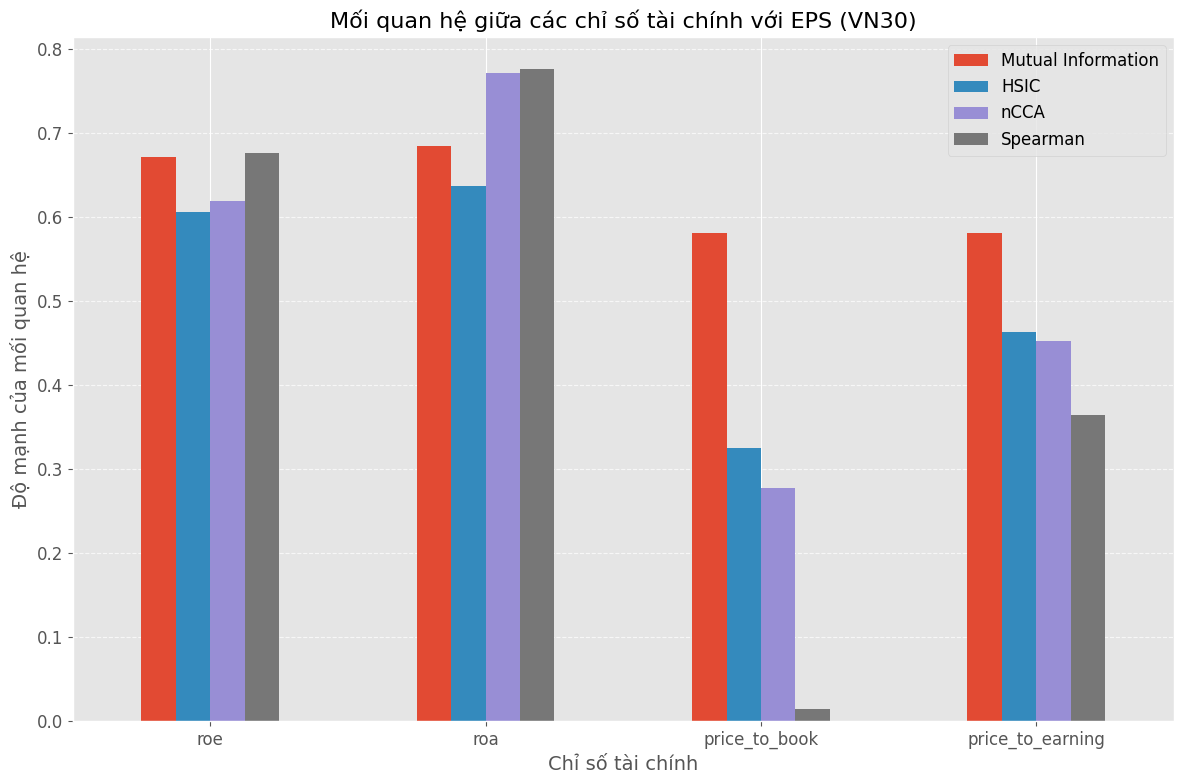

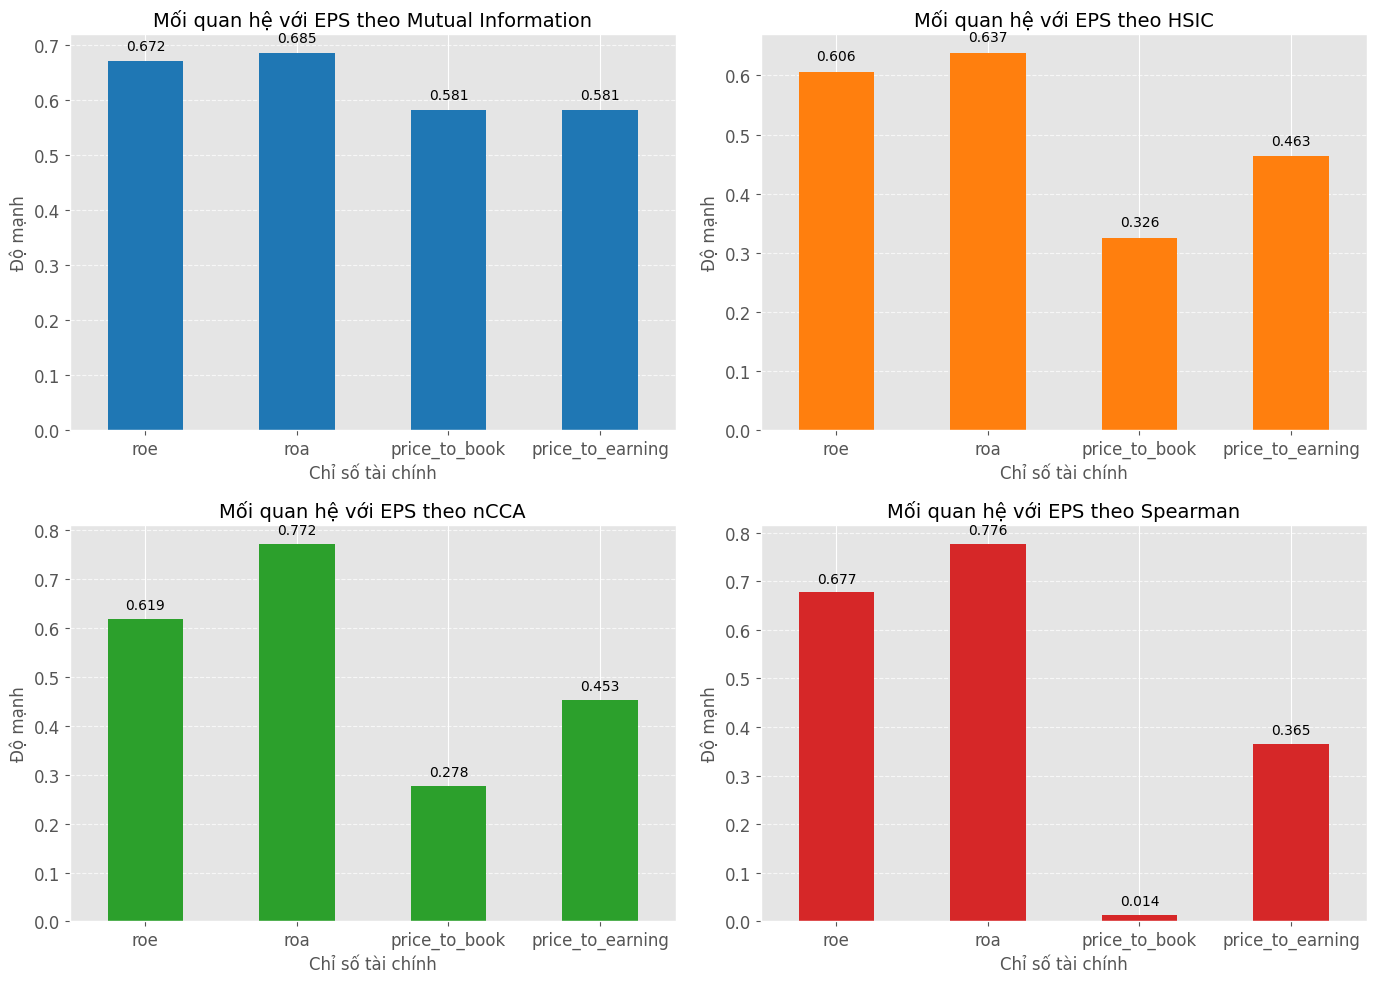

<Figure size 1200x800 with 0 Axes>

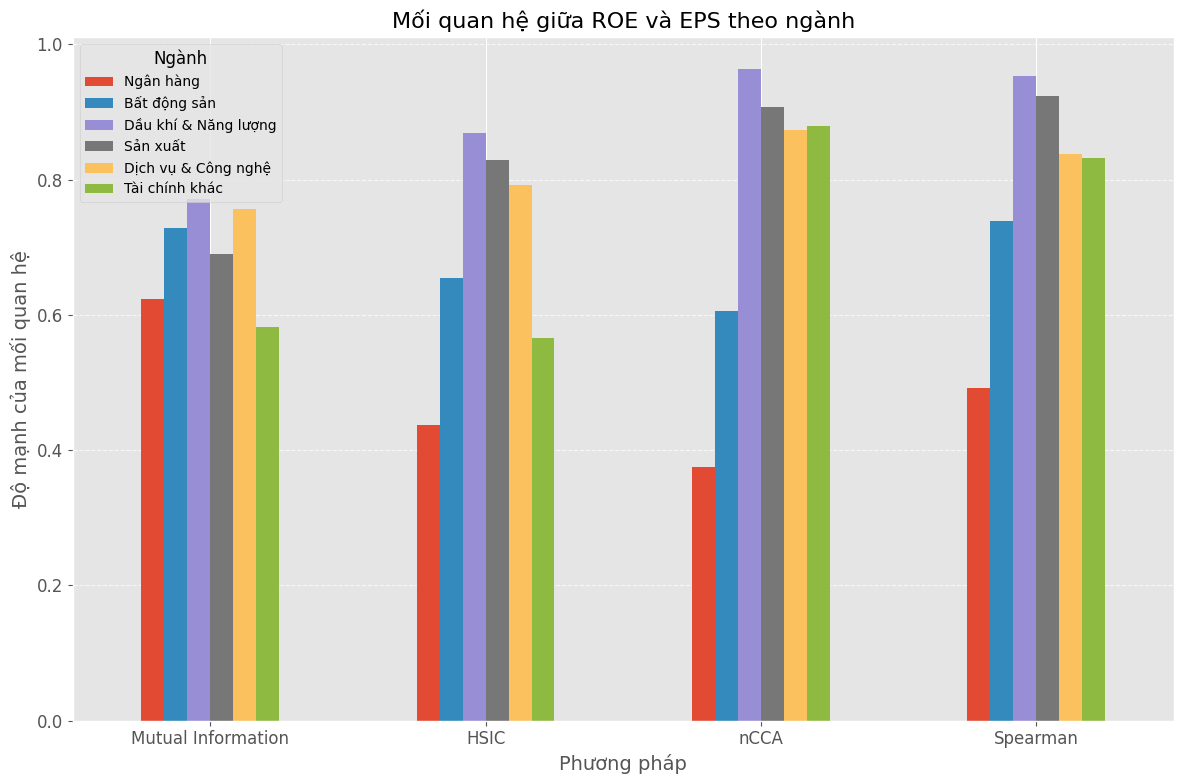

<Figure size 1200x800 with 0 Axes>

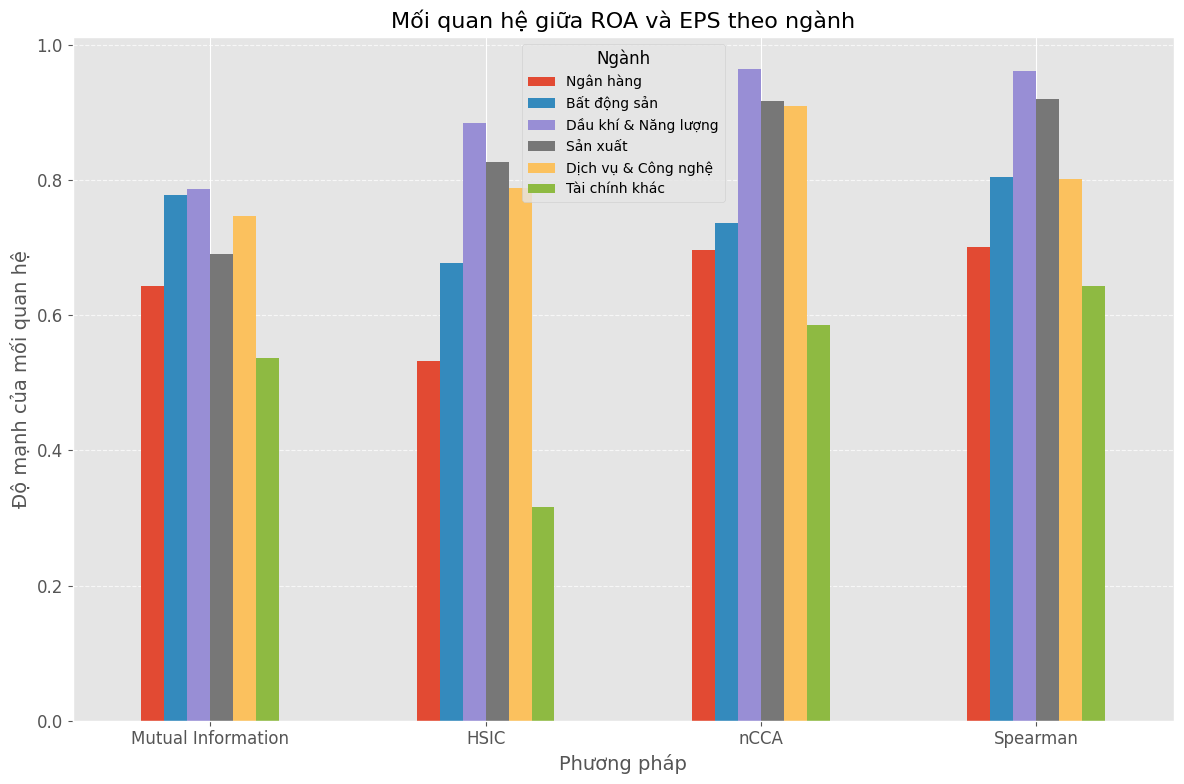

<Figure size 1200x800 with 0 Axes>

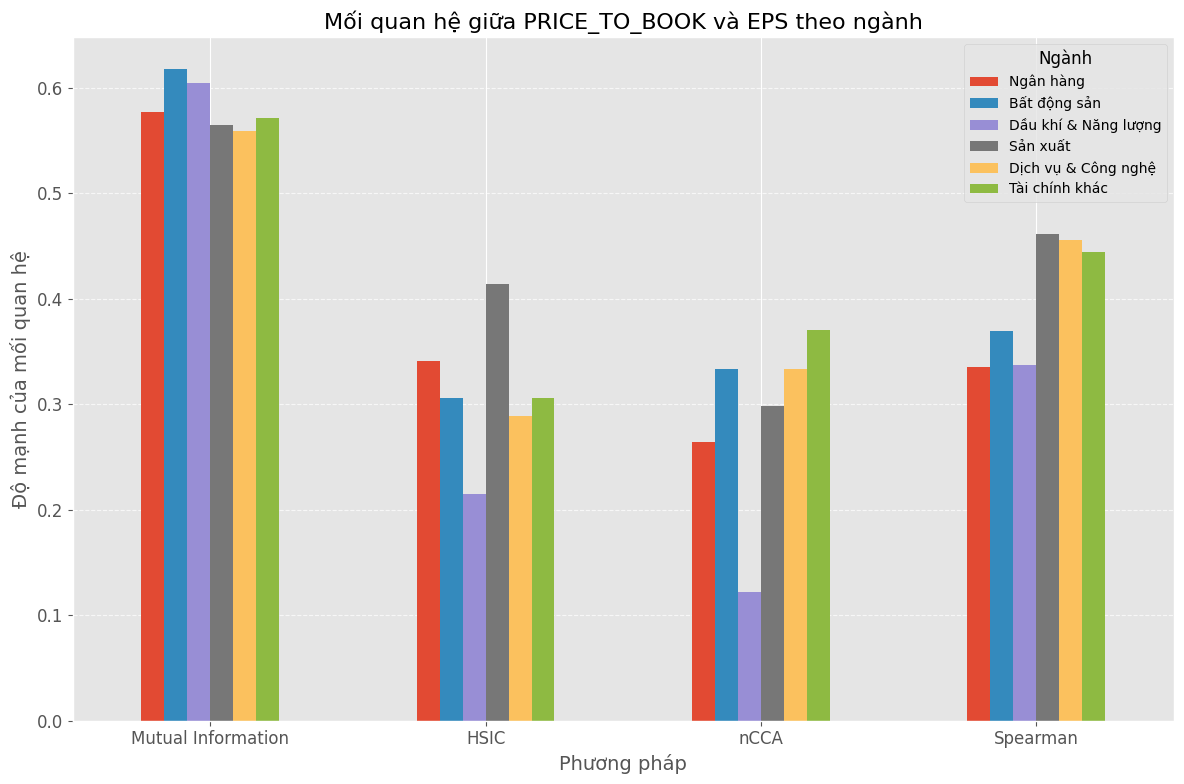

<Figure size 1200x800 with 0 Axes>

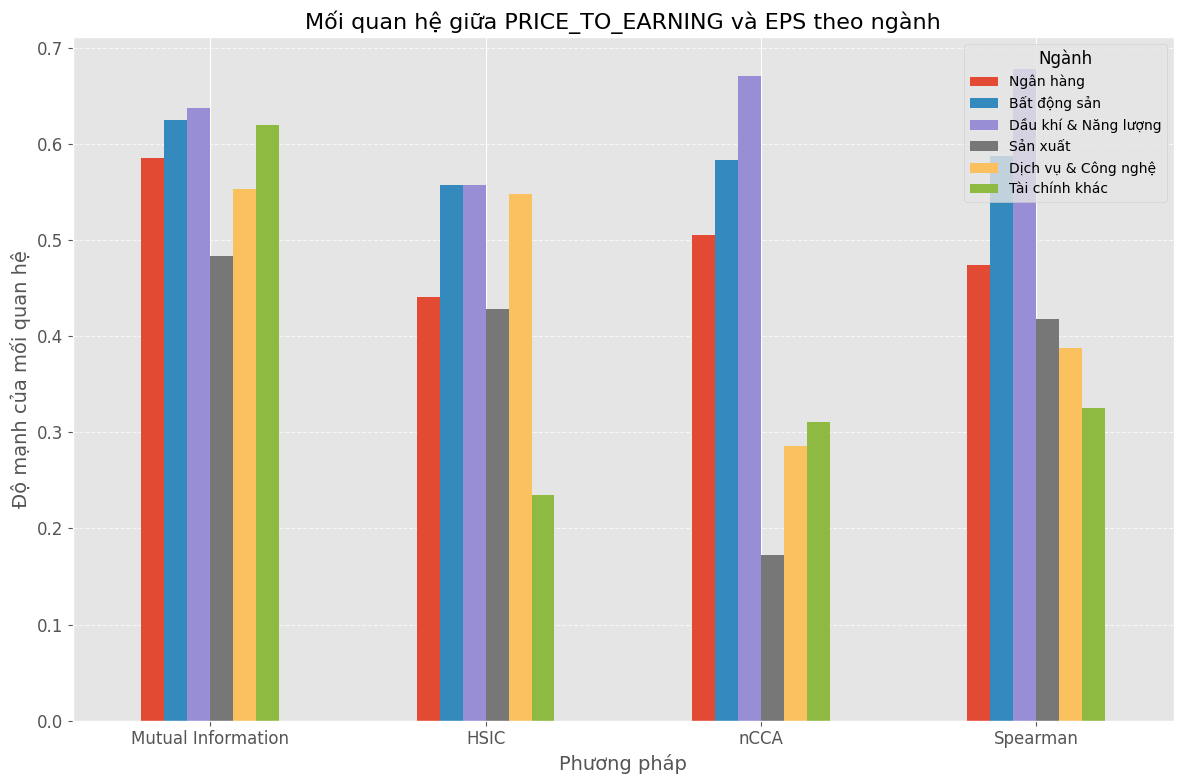

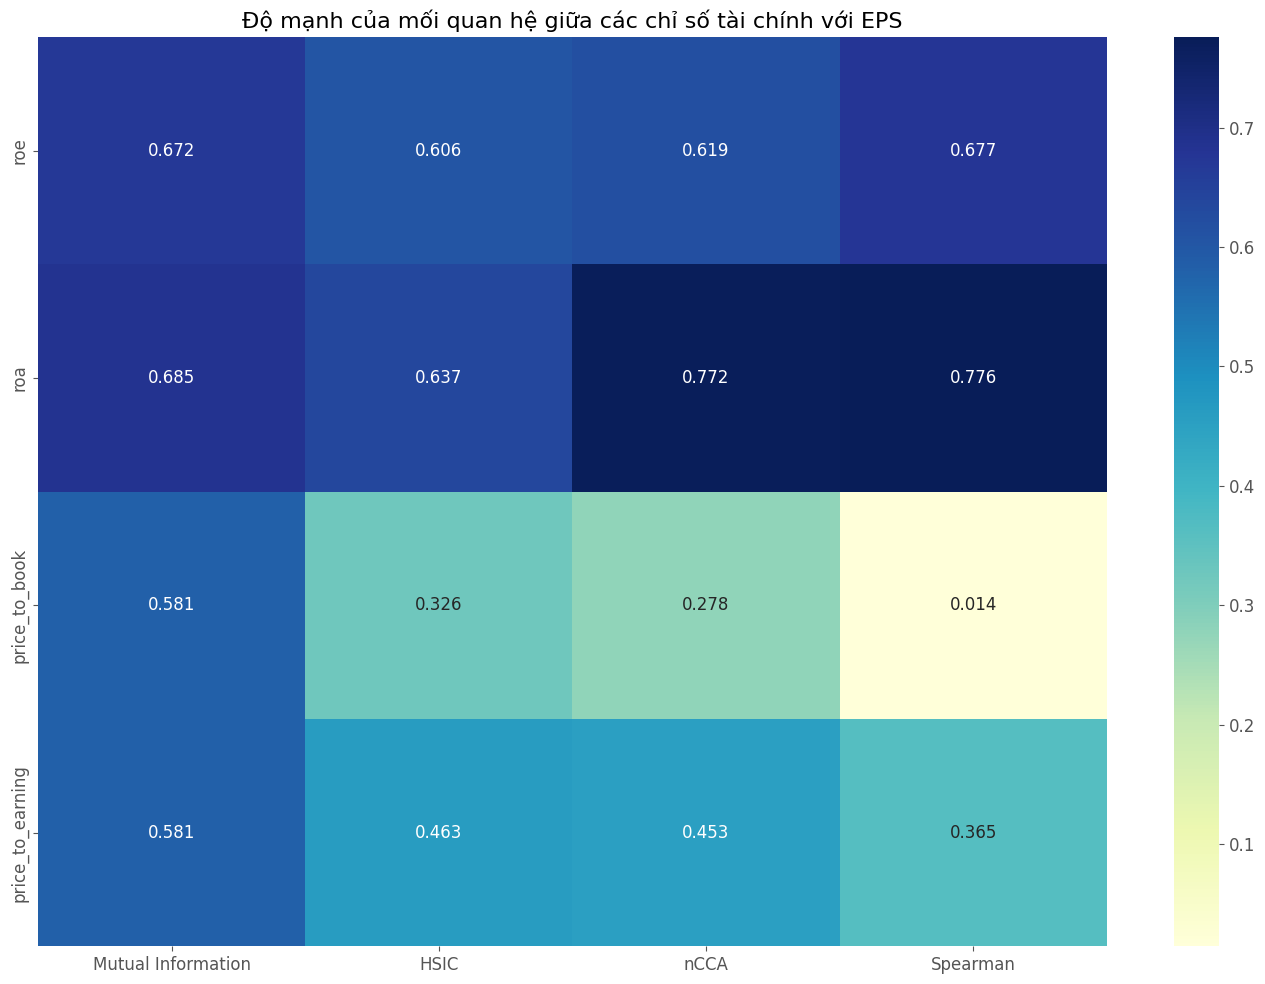

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import rbf_kernel
import warnings
warnings.filterwarnings('ignore')

# Danh sách các công ty VN30
vn30 = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 
        'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 
        'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

# Chỉ số cần phân tích
indicators = ['roe', 'roa', 'price_to_book', 'price_to_earning', 'earning_per_share']

# Function để đọc và xử lý dữ liệu
def load_data(ticker):
    file_path = f'../data/vn30/metric/{ticker}.csv'
    try:
        df = pd.read_csv(file_path)
        # Chuyển period thành datetime để sắp xếp chính xác
        df['period'] = pd.to_datetime(df['period'])
        # Lọc dữ liệu từ Q1-2020 đến Q4-2024
        mask = (df['period'] >= '2020-01-01') & (df['period'] <= '2024-12-31')
        return df[mask].sort_values('period')
    except Exception as e:
        print(f"Lỗi khi đọc dữ liệu {ticker}: {e}")
        return None

# Đọc dữ liệu cho tất cả công ty VN30
company_data = {}
for company in vn30:
    data = load_data(company)
    if data is not None and not data.empty:
        # Kiểm tra xem dữ liệu có chứa tất cả các chỉ số cần thiết không
        if all(indicator in data.columns for indicator in indicators):
            company_data[company] = data

print(f"Đã đọc dữ liệu thành công cho {len(company_data)} trong số {len(vn30)} công ty VN30")

# Gộp dữ liệu từ tất cả công ty
all_data = []
for company, data in company_data.items():
    data_subset = data[indicators + ['period']].copy()
    data_subset['company'] = company
    all_data.append(data_subset)

combined_data = pd.concat(all_data)
print(f"Tổng số quan sát: {len(combined_data)}")

# 1. Mutual Information Score
def calculate_mutual_information(x, y, bins=10):
    """
    Tính toán điểm thông tin tương hỗ (mutual information) giữa hai biến
    """
    # Chuyển đổi dữ liệu liên tục thành bins cho mutual information
    x_binned = pd.cut(x, bins=bins, labels=False)
    y_binned = pd.cut(y, bins=bins, labels=False)
    
    # Loại bỏ các giá trị NaN
    mask = ~(np.isnan(x_binned) | np.isnan(y_binned))
    x_binned = x_binned[mask]
    y_binned = y_binned[mask]
    
    if len(x_binned) < 2:
        return np.nan
    
    mi = mutual_info_score(x_binned, y_binned)
    # Chuẩn hóa để có giá trị từ 0 đến 1
    entropy_x = stats.entropy(np.histogram(x_binned, bins=bins)[0])
    entropy_y = stats.entropy(np.histogram(y_binned, bins=bins)[0])
    
    if entropy_x == 0 or entropy_y == 0:
        return np.nan
    
    normalized_mi = mi / np.sqrt(entropy_x * entropy_y)
    return normalized_mi

# 2. HSIC (Hilbert-Schmidt Independence Criterion)
def hsic(x, y, sigma_x=None, sigma_y=None):
    """
    Tính toán HSIC giữa hai biến
    HSIC là số đo độ phụ thuộc giữa hai biến trong không gian Hilbert
    """
    n = len(x)
    if n < 5:  # Cần ít nhất 5 quan sát
        return np.nan
    
    x = x.reshape(-1, 1) if len(x.shape) == 1 else x
    y = y.reshape(-1, 1) if len(y.shape) == 1 else y
    
    # Tính sigma mặc định nếu không cung cấp
    if sigma_x is None:
        sigma_x = np.median(np.sqrt(np.sum((x[None, :] - x[:, None]) ** 2, axis=2))) / np.sqrt(2)
    if sigma_y is None:
        sigma_y = np.median(np.sqrt(np.sum((y[None, :] - y[:, None]) ** 2, axis=2))) / np.sqrt(2)
    
    # Tránh sigma = 0
    sigma_x = np.maximum(sigma_x, 1e-10)
    sigma_y = np.maximum(sigma_y, 1e-10)
    
    # Tính ma trận kernel
    K = rbf_kernel(x, gamma=1 / (2 * sigma_x ** 2))
    L = rbf_kernel(y, gamma=1 / (2 * sigma_y ** 2))
    
    # Tính ma trận trung tâm
    H = np.eye(n) - np.ones((n, n)) / n
    
    # Tính HSIC
    hsic_value = np.trace(K @ H @ L @ H) / (n ** 2)
    
    # Chuẩn hóa HSIC
    hsic_x = np.trace(K @ H @ K @ H) / (n ** 2)
    hsic_y = np.trace(L @ H @ L @ H) / (n ** 2)
    
    normalized_hsic = hsic_value / np.sqrt(hsic_x * hsic_y)
    return normalized_hsic

# 3. Non-linear Canonical Correlation Analysis (nCCA)
def nonlinear_cca_score(x, y, n_components=1, n_splits=5):
    """
    Tính điểm tương quan chính tắc (canonical correlation) giữa hai biến
    sử dụng phương pháp cross-validation để đánh giá tính mạnh của mối quan hệ
    """
    x = x.reshape(-1, 1) if len(x.shape) == 1 else x
    y = y.reshape(-1, 1) if len(y.shape) == 1 else y
    
    n = len(x)
    if n < 10:  # Cần ít nhất 10 quan sát
        return np.nan
    
    # Tạo bộ chia dữ liệu cho cross-validation
    kf = KFold(n_splits=min(n_splits, n), shuffle=True, random_state=42)
    
    correlations = []
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        try:
            # Áp dụng CCA tuyến tính
            cca = CCA(n_components=n_components)
            cca.fit(x_train, y_train)
            
            # Biến đổi dữ liệu test
            x_c, y_c = cca.transform(x_test, y_test)
            
            # Tính tương quan trên tập test
            corr = np.corrcoef(x_c.T, y_c.T)[0, 1]
            correlations.append(corr)
        except Exception as e:
            continue
    
    if not correlations:
        return np.nan
    
    # Lấy trung bình các tương quan
    return np.mean(correlations)

# Tạo matrices kết quả
n_indicators = len(indicators) - 1  # Trừ EPS
eps_index = indicators.index('earning_per_share')

mutual_info_matrix = np.zeros((len(company_data), n_indicators))
hsic_matrix = np.zeros((len(company_data), n_indicators))
ncca_matrix = np.zeros((len(company_data), n_indicators))
spearman_matrix = np.zeros((len(company_data), n_indicators))

# Danh sách các công ty có dữ liệu
companies_with_data = list(company_data.keys())

# Tính các độ đo quan hệ cho từng công ty
for i, company in enumerate(companies_with_data):
    data = company_data[company]
    
    # Tính ma trận tương quan Spearman
    corr_matrix = data[indicators].corr(method='spearman')
    
    for j, indicator in enumerate(indicators):
        if indicator == 'earning_per_share':
            continue
            
        # Lấy chỉ số của indicator trong danh sách (trừ EPS)
        indicator_idx = j if j < eps_index else j - 1
        
        # Lưu hệ số tương quan Spearman
        spearman_matrix[i, indicator_idx] = corr_matrix.loc[indicator, 'earning_per_share']
        
        x = data[indicator].values
        y = data['earning_per_share'].values
        
        # Loại bỏ các giá trị NaN
        mask = ~(np.isnan(x) | np.isnan(y))
        x, y = x[mask], y[mask]
        
        if len(x) > 4:  # Cần ít nhất 5 điểm dữ liệu
            # Tính các độ đo
            mutual_info_matrix[i, indicator_idx] = calculate_mutual_information(x, y)
            hsic_matrix[i, indicator_idx] = hsic(x, y)
            ncca_matrix[i, indicator_idx] = nonlinear_cca_score(x, y)

# Tạo DataFrame cho từng độ đo
indicator_names = [ind for ind in indicators if ind != 'earning_per_share']

mi_df = pd.DataFrame(mutual_info_matrix, index=companies_with_data, columns=indicator_names)
hsic_df = pd.DataFrame(hsic_matrix, index=companies_with_data, columns=indicator_names)
ncca_df = pd.DataFrame(ncca_matrix, index=companies_with_data, columns=indicator_names)
spearman_df = pd.DataFrame(spearman_matrix, index=companies_with_data, columns=indicator_names)

# Tính giá trị trung bình cho từng chỉ số qua tất cả các công ty
mi_means = mi_df.mean()
hsic_means = hsic_df.mean()
ncca_means = ncca_df.mean()
spearman_means = spearman_df.mean().abs()  # Lấy giá trị tuyệt đối vì chúng ta quan tâm đến độ mạnh của mối quan hệ

# Tạo DataFrame tổng hợp để vẽ biểu đồ
summary_data = pd.DataFrame({
    'Mutual Information': mi_means,
    'HSIC': hsic_means,
    'nCCA': ncca_means,
    'Spearman': spearman_means
})

print("Tổng hợp kết quả:")
print(summary_data.round(3))

# Tạo biểu đồ cột để so sánh mối quan hệ
plt.figure(figsize=(12, 8))
summary_data.plot(kind='bar', figsize=(12, 8))
plt.title('Mối quan hệ giữa các chỉ số tài chính với EPS (VN30)', fontsize=16)
plt.xlabel('Chỉ số tài chính', fontsize=14)
plt.ylabel('Độ mạnh của mối quan hệ', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('relationship_strength_overall.png')

# Tạo biểu đồ riêng từng phương pháp
methods = ['Mutual Information', 'HSIC', 'nCCA', 'Spearman']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, method in enumerate(methods):
    ax = axes[i]
    summary_data[method].plot(kind='bar', ax=ax, color=plt.cm.tab10(i))
    ax.set_title(f'Mối quan hệ với EPS theo {method}', fontsize=14)
    ax.set_xlabel('Chỉ số tài chính', fontsize=12)
    ax.set_ylabel('Độ mạnh', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=0)
    
    # Thêm giá trị lên đầu cột
    for j, v in enumerate(summary_data[method]):
        ax.text(j, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('relationship_strength_by_method.png')

# Định nghĩa các nhóm ngành
industry_groups = {
    'Ngân hàng': ['ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB', 'SSB', 'STB', 'TCB', 'TPB', 'VCB', 'VIB', 'VPB'],
    'Bất động sản': ['BCM', 'VHM', 'VIC', 'VRE'],
    'Dầu khí & Năng lượng': ['GAS', 'PLX', 'GVR'],
    'Sản xuất': ['HPG', 'MSN', 'SAB', 'VNM'],
    'Dịch vụ & Công nghệ': ['FPT', 'MWG', 'VJC'],
    'Tài chính khác': ['BVH', 'SSI']
}

# Tạo dict ngược để xác định ngành cho mỗi công ty
company_to_industry = {}
for industry, companies in industry_groups.items():
    for company in companies:
        company_to_industry[company] = industry

# Phân tích theo ngành
industry_summary = {}

for industry, companies in industry_groups.items():
    # Lọc các công ty thuộc ngành và có dữ liệu
    industry_companies = [c for c in companies if c in company_data]
    
    if not industry_companies:
        continue
    
    industry_data = {}
    for indicator in indicator_names:
        industry_data[indicator] = {
            'Mutual Information': mi_df.loc[industry_companies, indicator].mean(),
            'HSIC': hsic_df.loc[industry_companies, indicator].mean(),
            'nCCA': ncca_df.loc[industry_companies, indicator].mean(),
            'Spearman': spearman_df.loc[industry_companies, indicator].abs().mean()
        }
    
    industry_summary[industry] = industry_data

# Vẽ biểu đồ theo ngành cho từng chỉ số
for indicator in indicator_names:
    plt.figure(figsize=(12, 8))
    
    # Tạo DataFrame cho biểu đồ
    data = {industry: [industry_summary[industry][indicator][method] 
                       for method in methods] 
            for industry in industry_summary}
    
    df = pd.DataFrame(data, index=methods)
    df.plot(kind='bar', figsize=(12, 8))
    
    plt.title(f'Mối quan hệ giữa {indicator.upper()} và EPS theo ngành', fontsize=16)
    plt.xlabel('Phương pháp', fontsize=14)
    plt.ylabel('Độ mạnh của mối quan hệ', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=10, title='Ngành', title_fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'relationship_{indicator}_by_industry.png')

# Vẽ biểu đồ tổng hợp (heatmap)
plt.figure(figsize=(14, 10))

# Tạo ma trận tổng hợp
combined_matrix = np.zeros((len(indicator_names), len(methods)))
for i, indicator in enumerate(indicator_names):
    for j, method in enumerate(methods):
        combined_matrix[i, j] = summary_data.loc[indicator, method]

sns.heatmap(combined_matrix, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=methods, yticklabels=indicator_names)
plt.title('Độ mạnh của mối quan hệ giữa các chỉ số tài chính với EPS', fontsize=16)
plt.tight_layout()
plt.savefig('relationship_heatmap.png')

print('Đã tạo các biểu đồ trực quan hóa.')